## 1. Gerekli Kütüphaneleri İçe Aktar

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

print("Kütüphaneler başarıyla yüklendi.")

Kütüphaneler başarıyla yüklendi.


## 2. Veri Setini Yükleme ve Hazırlama

In [8]:
# Veri seti yolunun tanımlanması
dataset_path = 'dataset'
img_size = 128

# Sınıfları al
classes = sorted(os.listdir(dataset_path))
num_classes = len(classes)
print(f"Sınıflar: {classes}")
print(f"Sınıf sayısı: {num_classes}")

# Görüntüleri yükle
images = []
labels = []

for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            if img_name.endswith(('.jpg', '.jpeg', '.png', '.JPG', '.PNG')):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = load_img(img_path, target_size=(img_size, img_size))
                    img_array = img_to_array(img) / 255.0
                    images.append(img_array)
                    labels.append(class_idx)
                except Exception as e:
                    print(f"Hata: {img_path} - {e}")

images = np.array(images)
labels = np.array(labels)

print(f"\nToplam görüntü sayısı: {len(images)}")
print(f"Görüntü şekli: {images[0].shape}")

Sınıflar: ['class1', 'class2']
Sınıf sayısı: 2

Toplam görüntü sayısı: 100
Görüntü şekli: (128, 128, 3)


## 3. Veri Setini Eğitim ve Test Setlerine Böl

In [9]:
# %80 eğitim, %20 test
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")

# Etiketleri one-hot encode et
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

Eğitim seti boyutu: (80, 128, 128, 3)
Test seti boyutu: (20, 128, 128, 3)


## 4. ImageDataGenerator ile Online Veri Artırımı Tanımla

**Artırım Tekikleri:**
- Rotation: ±15 derece
- Width/Height Shift: ±10%
- Horizontal Flip: %50 olasılıkla
- Zoom: %10-20%

In [10]:
# Eğitim seti için veri artırımı
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

print("Veri artırımı tanımlanmıştır.")

Veri artırımı tanımlanmıştır.


## 5. Hiperparametre Optimizasyonu için Deney Yapısı

**Değiştirilecek Parametreler:**
- Filtre sayısı (32/64 → 64/128)
- Batch size (32 → 64)
- Öğrenme oranı (0.001 → 0.0005)
- Dropout oranları (0.25/0.5 → 0.3/0.4)

In [11]:
# Hiperparametre kombinasyonları
hyperparameters = [
    {
        'name': 'Config_1',
        'filters1': 32,
        'filters2': 64,
        'batch_size': 32,
        'learning_rate': 0.001,
        'dropout1': 0.25,
        'dropout2': 0.5,
        'epochs': 30
    },
    {
        'name': 'Config_2',
        'filters1': 64,
        'filters2': 128,
        'batch_size': 32,
        'learning_rate': 0.001,
        'dropout1': 0.25,
        'dropout2': 0.5,
        'epochs': 30
    },
    {
        'name': 'Config_3',
        'filters1': 32,
        'filters2': 64,
        'batch_size': 64,
        'learning_rate': 0.0005,
        'dropout1': 0.3,
        'dropout2': 0.4,
        'epochs': 30
    },
    {
        'name': 'Config_4',
        'filters1': 64,
        'filters2': 128,
        'batch_size': 64,
        'learning_rate': 0.0005,
        'dropout1': 0.3,
        'dropout2': 0.4,
        'epochs': 30
    },
    {
        'name': 'Config_5',
        'filters1': 48,
        'filters2': 96,
        'batch_size': 48,
        'learning_rate': 0.0008,
        'dropout1': 0.3,
        'dropout2': 0.5,
        'epochs': 30
    }
]

print(f"Toplam {len(hyperparameters)} farklı konfigürasyon denenecek.")

Toplam 5 farklı konfigürasyon denenecek.


In [12]:
# Tüm konfigürasyonları eğit
results = []
models_dict = {}

for i, config in enumerate(hyperparameters):
    print(f"\n{'='*80}")
    print(f"Eğitim {i+1}/{len(hyperparameters)}: {config['name']}")
    print(f"{'='*80}")
    
    # Model oluştur
    model = Sequential([
        Conv2D(config['filters1'], (3, 3), activation='relu', input_shape=(img_size, img_size, 3),
               kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Conv2D(config['filters2'], (3, 3), activation='relu',
               kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(config['dropout1']),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(config['dropout2']),
        Dense(num_classes, activation='softmax')
    ])
    
    # Model derle
    optimizer = Adam(learning_rate=config['learning_rate'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Early stopping tanımla
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Eğitim verisini artırarak eğit
    train_generator = train_datagen.flow(
        X_train, y_train_encoded,
        batch_size=config['batch_size'],
        shuffle=True
    )
    
    test_generator = test_datagen.flow(
        X_test, y_test_encoded,
        batch_size=config['batch_size'],
        shuffle=False
    )
    
    # Modeli eğit
    print(f"Modeli eğitiyorum... ({config['epochs']} epoch)")
    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // config['batch_size'],
        epochs=config['epochs'],
        validation_data=test_generator,
        validation_steps=len(X_test) // config['batch_size'],
        callbacks=[early_stop],
        verbose=0
    )
    
    # Test seti üzerinde değerlendir
    test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
    
    # Sonuçları kaydet
    result = {
        'Configuration': config['name'],
        'Filters': f"{config['filters1']}/{config['filters2']}",
        'Batch_Size': config['batch_size'],
        'Learning_Rate': config['learning_rate'],
        'Dropout': f"{config['dropout1']}/{config['dropout2']}",
        'Test_Accuracy': f"{test_accuracy*100:.2f}%",
        'Test_Loss': f"{test_loss:.4f}"
    }
    
    results.append(result)
    models_dict[config['name']] = (model, history)
    
    print(f"Test Doğruluğu: {test_accuracy*100:.2f}%")
    print(f"Test Kayıpı: {test_loss:.4f}")

print(f"\n{'='*80}")
print(f"Tüm {len(hyperparameters)} konfigürasyon başarıyla eğitildi!")
print(f"{'='*80}")


Eğitim 1/5: Config_1
Modeli eğitiyorum... (30 epoch)
Test Doğruluğu: 100.00%
Test Kayıpı: 0.2408

Eğitim 2/5: Config_2
Modeli eğitiyorum... (30 epoch)
Test Doğruluğu: 100.00%
Test Kayıpı: 0.3172

Eğitim 3/5: Config_3
Modeli eğitiyorum... (30 epoch)
Test Doğruluğu: 100.00%
Test Kayıpı: 0.2280

Eğitim 4/5: Config_4
Modeli eğitiyorum... (30 epoch)
Test Doğruluğu: 100.00%
Test Kayıpı: 0.2733

Eğitim 5/5: Config_5
Modeli eğitiyorum... (30 epoch)
Test Doğruluğu: 100.00%
Test Kayıpı: 0.2861

Tüm 5 konfigürasyon başarıyla eğitildi!


## 7. Sonuçlar Tablosu


En iyi model: Config_1
Test Doğruluğu: 100.00%


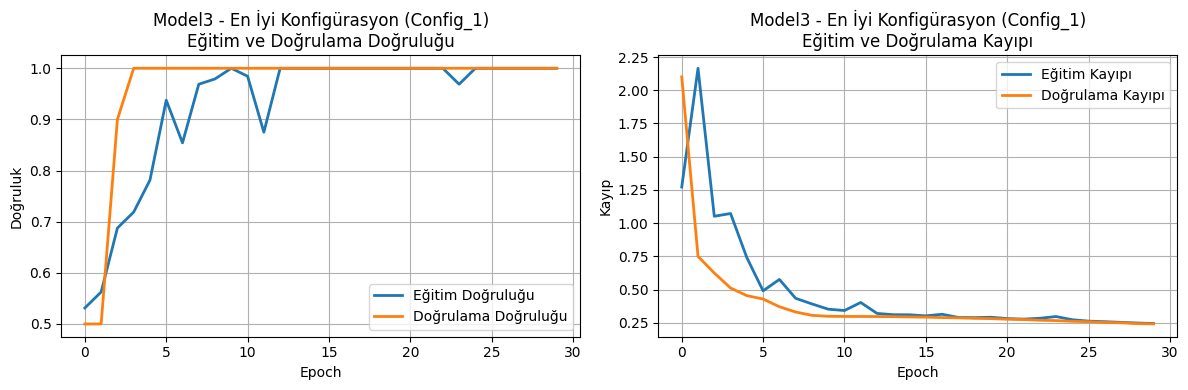

In [13]:
# En iyi modeli bul
best_idx = 0
best_accuracy = 0.0
for i, result in enumerate(results):
    acc = float(result['Test_Accuracy'].replace('%', ''))
    if acc > best_accuracy:
        best_accuracy = acc
        best_idx = i

best_config_name = hyperparameters[best_idx]['name']
best_model, best_history = models_dict[best_config_name]

print(f"\nEn iyi model: {best_config_name}")
print(f"Test Doğruluğu: {best_accuracy:.2f}%")

# En iyi modelin grafiklerini çiz
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(best_history.history['accuracy'], label='Eğitim Doğruluğu', linewidth=2)
plt.plot(best_history.history['val_accuracy'], label='Doğrulama Doğruluğu', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.title(f'Model3 - En İyi Konfigürasyon ({best_config_name})\nEğitim ve Doğrulama Doğruluğu')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'], label='Eğitim Kayıpı', linewidth=2)
plt.plot(best_history.history['val_loss'], label='Doğrulama Kayıpı', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.title(f'Model3 - En İyi Konfigürasyon ({best_config_name})\nEğitim ve Doğrulama Kayıpı')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 8. En İyi Modeli Seç ve Grafikler Çiz

In [14]:
# Pandas DataFrame oluştur
results_df = pd.DataFrame(results)
print("\n" + "="*120)
print("MODEL3 - HIPERPARAMETRE OPTİMİZASYON SONUÇLARI")
print("="*120)
print(results_df.to_string(index=False))
print("="*120)

# Excel veya CSV'ye kaydet
results_df.to_csv('model3_hyperparameter_results.csv', index=False)
print("\nSonuçlar 'model3_hyperparameter_results.csv' dosyasına kaydedilmiştir.")


MODEL3 - HIPERPARAMETRE OPTİMİZASYON SONUÇLARI
Configuration Filters  Batch_Size  Learning_Rate  Dropout Test_Accuracy Test_Loss
     Config_1   32/64          32         0.0010 0.25/0.5       100.00%    0.2408
     Config_2  64/128          32         0.0010 0.25/0.5       100.00%    0.3172
     Config_3   32/64          64         0.0005  0.3/0.4       100.00%    0.2280
     Config_4  64/128          64         0.0005  0.3/0.4       100.00%    0.2733
     Config_5   48/96          48         0.0008  0.3/0.5       100.00%    0.2861

Sonuçlar 'model3_hyperparameter_results.csv' dosyasına kaydedilmiştir.


## 9. Hiperparametre Değişikliklerinin Etkisi Analizi

In [15]:
print("\n" + "="*80)
print("HIPERPARAMETRE DEĞİŞİKLİKLERİNİN ETKİSİ ANALİZİ")
print("="*80)

print("\n1. FİLTRE SAYISI ETKİSİ:")
print("-" * 40)
print(f"   32/64 filtreler (Config_1): {results[0]['Test_Accuracy']}")
print(f"   64/128 filtreler (Config_2): {results[1]['Test_Accuracy']}")

print("\n2. BATCH SIZE ETKİSİ:")
print("-" * 40)
print(f"   Batch Size=32 (Config_1): {results[0]['Test_Accuracy']}")
print(f"   Batch Size=64 (Config_3): {results[2]['Test_Accuracy']}")

print("\n3. ÖĞRENME ORANI ETKİSİ:")
print("-" * 40)
print(f"   LR=0.001 (Config_1): {results[0]['Test_Accuracy']}")
print(f"   LR=0.0005 (Config_3): {results[2]['Test_Accuracy']}")

print("\n4. DROPOUT ETKİSİ:")
print("-" * 40)
print(f"   Dropout=[0.25, 0.5] (Config_1): {results[0]['Test_Accuracy']}")
print(f"   Dropout=[0.3, 0.4] (Config_3): {results[2]['Test_Accuracy']}")

print("\n" + "="*80)


HIPERPARAMETRE DEĞİŞİKLİKLERİNİN ETKİSİ ANALİZİ

1. FİLTRE SAYISI ETKİSİ:
----------------------------------------
   32/64 filtreler (Config_1): 100.00%
   64/128 filtreler (Config_2): 100.00%

2. BATCH SIZE ETKİSİ:
----------------------------------------
   Batch Size=32 (Config_1): 100.00%
   Batch Size=64 (Config_3): 100.00%

3. ÖĞRENME ORANI ETKİSİ:
----------------------------------------
   LR=0.001 (Config_1): 100.00%
   LR=0.0005 (Config_3): 100.00%

4. DROPOUT ETKİSİ:
----------------------------------------
   Dropout=[0.25, 0.5] (Config_1): 100.00%
   Dropout=[0.3, 0.4] (Config_3): 100.00%



## 10. En İyi Modeli Kaydet

In [ ]:
# Tüm modelleri karşılaştırmak için grafik çiz
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Model3 - Tüm Konfigürasyonların Eğitim ve Doğrulama Performansı', fontsize=16, fontweight='bold')

for idx, (config_name, (model, history)) in enumerate(models_dict.items()):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]
    
    # Accuracy grafiği
    ax.plot(history.history['accuracy'], label='Eğitim Doğruluğu', linewidth=2, marker='o', markersize=3)
    ax.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', linewidth=2, marker='s', markersize=3)
    
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Doğruluk', fontsize=10)
    ax.set_title(f'{config_name}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Test doğruluğu karşılaştırması
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

config_names = [result['Configuration'] for result in results]
test_accuracies = [float(result['Test_Accuracy'].replace('%', '')) for result in results]
test_losses = [float(result['Test_Loss']) for result in results]

# Bar chart for accuracy
colors = ['green' if acc == max(test_accuracies) else 'skyblue' for acc in test_accuracies]
ax1.bar(config_names, test_accuracies, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Test Doğruluğu (%)', fontsize=12)
ax1.set_title('Tüm Konfigürasyonların Test Doğruluğu Karşılaştırması', fontsize=12, fontweight='bold')
ax1.set_ylim([0, 105])
for i, v in enumerate(test_accuracies):
    ax1.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')
ax1.grid(True, axis='y', alpha=0.3)

# Bar chart for loss
colors_loss = ['green' if loss == min(test_losses) else 'lightcoral' for loss in test_losses]
ax2.bar(config_names, test_losses, color=colors_loss, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Test Kayıpı', fontsize=12)
ax2.set_title('Tüm Konfigürasyonların Test Kayıpı Karşılaştırması', fontsize=12, fontweight='bold')
for i, v in enumerate(test_losses):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Detaylı tablo oluştur
print("\n" + "="*150)
print("TÜM KONFİGÜRASYONLARIN DETAYLI KARŞILAŞTIRMASI")
print("="*150)
print(results_df.to_string(index=False))
print("="*150)

In [16]:
best_model.save('model3_optimized.h5')
print(f"En iyi model ({best_config_name}) başarıyla kaydedilmiştir.")
print(f"Dosya adı: model3_optimized.h5")

En iyi model (Config_1) başarıyla kaydedilmiştir.
Dosya adı: model3_optimized.h5


## 11. Tüm Modellerin Karşılaştırma Grafiği